Training a neural network to predict $\delta C_9$ on an event-by-event basis (classification)

Import Libraries

In [1]:
import numpy as np

from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn.functional import log_softmax

from library.nn_training import train_and_eval, select_device
from library.plotting import setup_high_quality_mpl_params, plot_loss_curves, plot_likelihood_over_bins, plot_prediction_linearity
from library.datasets import Aggregated_Signal_Binned_Dataset
from library.util import bootstrap_over_bins

In [2]:
setup_high_quality_mpl_params()

Define Helper Functions

In [3]:
def predict_set_likelihood(x, model):
    """
    x : torch tensor of events
    model : torch model
    """
    model.eval()
    with torch.no_grad():
        logits = model(x)
        pred = torch.sum(log_softmax(logits, dim=1), axis=0)
    return pred


def predict_likelihood_over_bins(x, y, model):
    """
    x : torch tensor of events
    y : torch tensor of bins
    model : torch model
    """
    assert len(x) == len(y)
    bins = np.unique(y.cpu())
    preds = []
    for bin in bins:
        bin_x = x[y==bin]
        pred = predict_set_likelihood(bin_x, model).cpu().numpy()
        preds.append(np.expand_dims(pred, axis=0))
    preds = np.concatenate(preds, axis=0)
    assert preds.shape == (len(bins), len(bins))
    return preds


def predict_likelihood_over_bootstrapped_trials(x, y, n_trials, n_events, model, device):
    """
    x : torch tensor of events
    y : torch tensor of bins
    n_trials : number of bootstrapped sample sets
    n_events : number of events to bootstrap per sample set
    """
    x_np = x.cpu().numpy()
    y_np = y.cpu().numpy()
    pred_bins_over_trials = []
    for _ in range(n_trials):
        boot_x, boot_y = bootstrap_over_bins(x_np, y_np, n_events)
        boot_x = torch.from_numpy(boot_x).to(device)
        boot_y = torch.from_numpy(boot_y).to(device)
        preds = predict_likelihood_over_bins(boot_x, boot_y, model)
        pred_bins = np.argmax(preds, axis=1)
        pred_bins_over_trials.append(np.expand_dims(pred_bins, axis=0))
    pred_bins_over_trials = np.concatenate(pred_bins_over_trials)
    return pred_bins_over_trials

Define Model

In [4]:
model_save_path = "../../state/new_physics/models/ebe_nn.pt"

class Event_By_Event_NN(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(4, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 44)
         )
        
        self.double()

    def forward(self, x):
        result = self.layers(x)
        return result
    


Select Device

In [5]:
device = select_device()

Device:  cuda


Load / Generate Datasets

In [6]:
level = "gen"
save_dir = "../../state/new_physics/data/processed"
raw_signal_dir = "../../state/new_physics/data/raw/signal"

train_dataset = Aggregated_Signal_Binned_Dataset(level=level, split="train", raw_trials=range(0,30), save_dir=save_dir)
# train_dataset.generate(raw_signal_dir)
train_dataset.load()
train_dataset.to(device)

eval_dataset = Aggregated_Signal_Binned_Dataset(level=level, split="eval", raw_trials=range(30,40), save_dir=save_dir)
# eval_dataset.generate(raw_signal_dir)
eval_dataset.load()
eval_dataset.to(device)


Train / Load Model


epoch 0 complete:
    Train loss: 3.7841395014951527
    Eval loss: 3.78297511948685

peak gpu memory usage: 10.94352 GB

epoch 1 complete:
    Train loss: 3.7824256027438685
    Eval loss: 3.781962733339932

peak gpu memory usage: 10.94352 GB

epoch 2 complete:
    Train loss: 3.7816291274700924
    Eval loss: 3.781273786082612

peak gpu memory usage: 10.94352 GB

epoch 3 complete:
    Train loss: 3.780896015774483
    Eval loss: 3.780622856101557

peak gpu memory usage: 10.94352 GB

epoch 4 complete:
    Train loss: 3.7801924343416844
    Eval loss: 3.780008740125028

peak gpu memory usage: 10.94352 GB

epoch 5 complete:
    Train loss: 3.7795385166894455
    Eval loss: 3.7794882146807582

peak gpu memory usage: 10.94352 GB

epoch 6 complete:
    Train loss: 3.7790938251742743
    Eval loss: 3.7790848119156166

peak gpu memory usage: 10.94352 GB

epoch 7 complete:
    Train loss: 3.7787863967378823
    Eval loss: 3.778880639384992

peak gpu memory usage: 10.94352 GB

epoch 8 complet

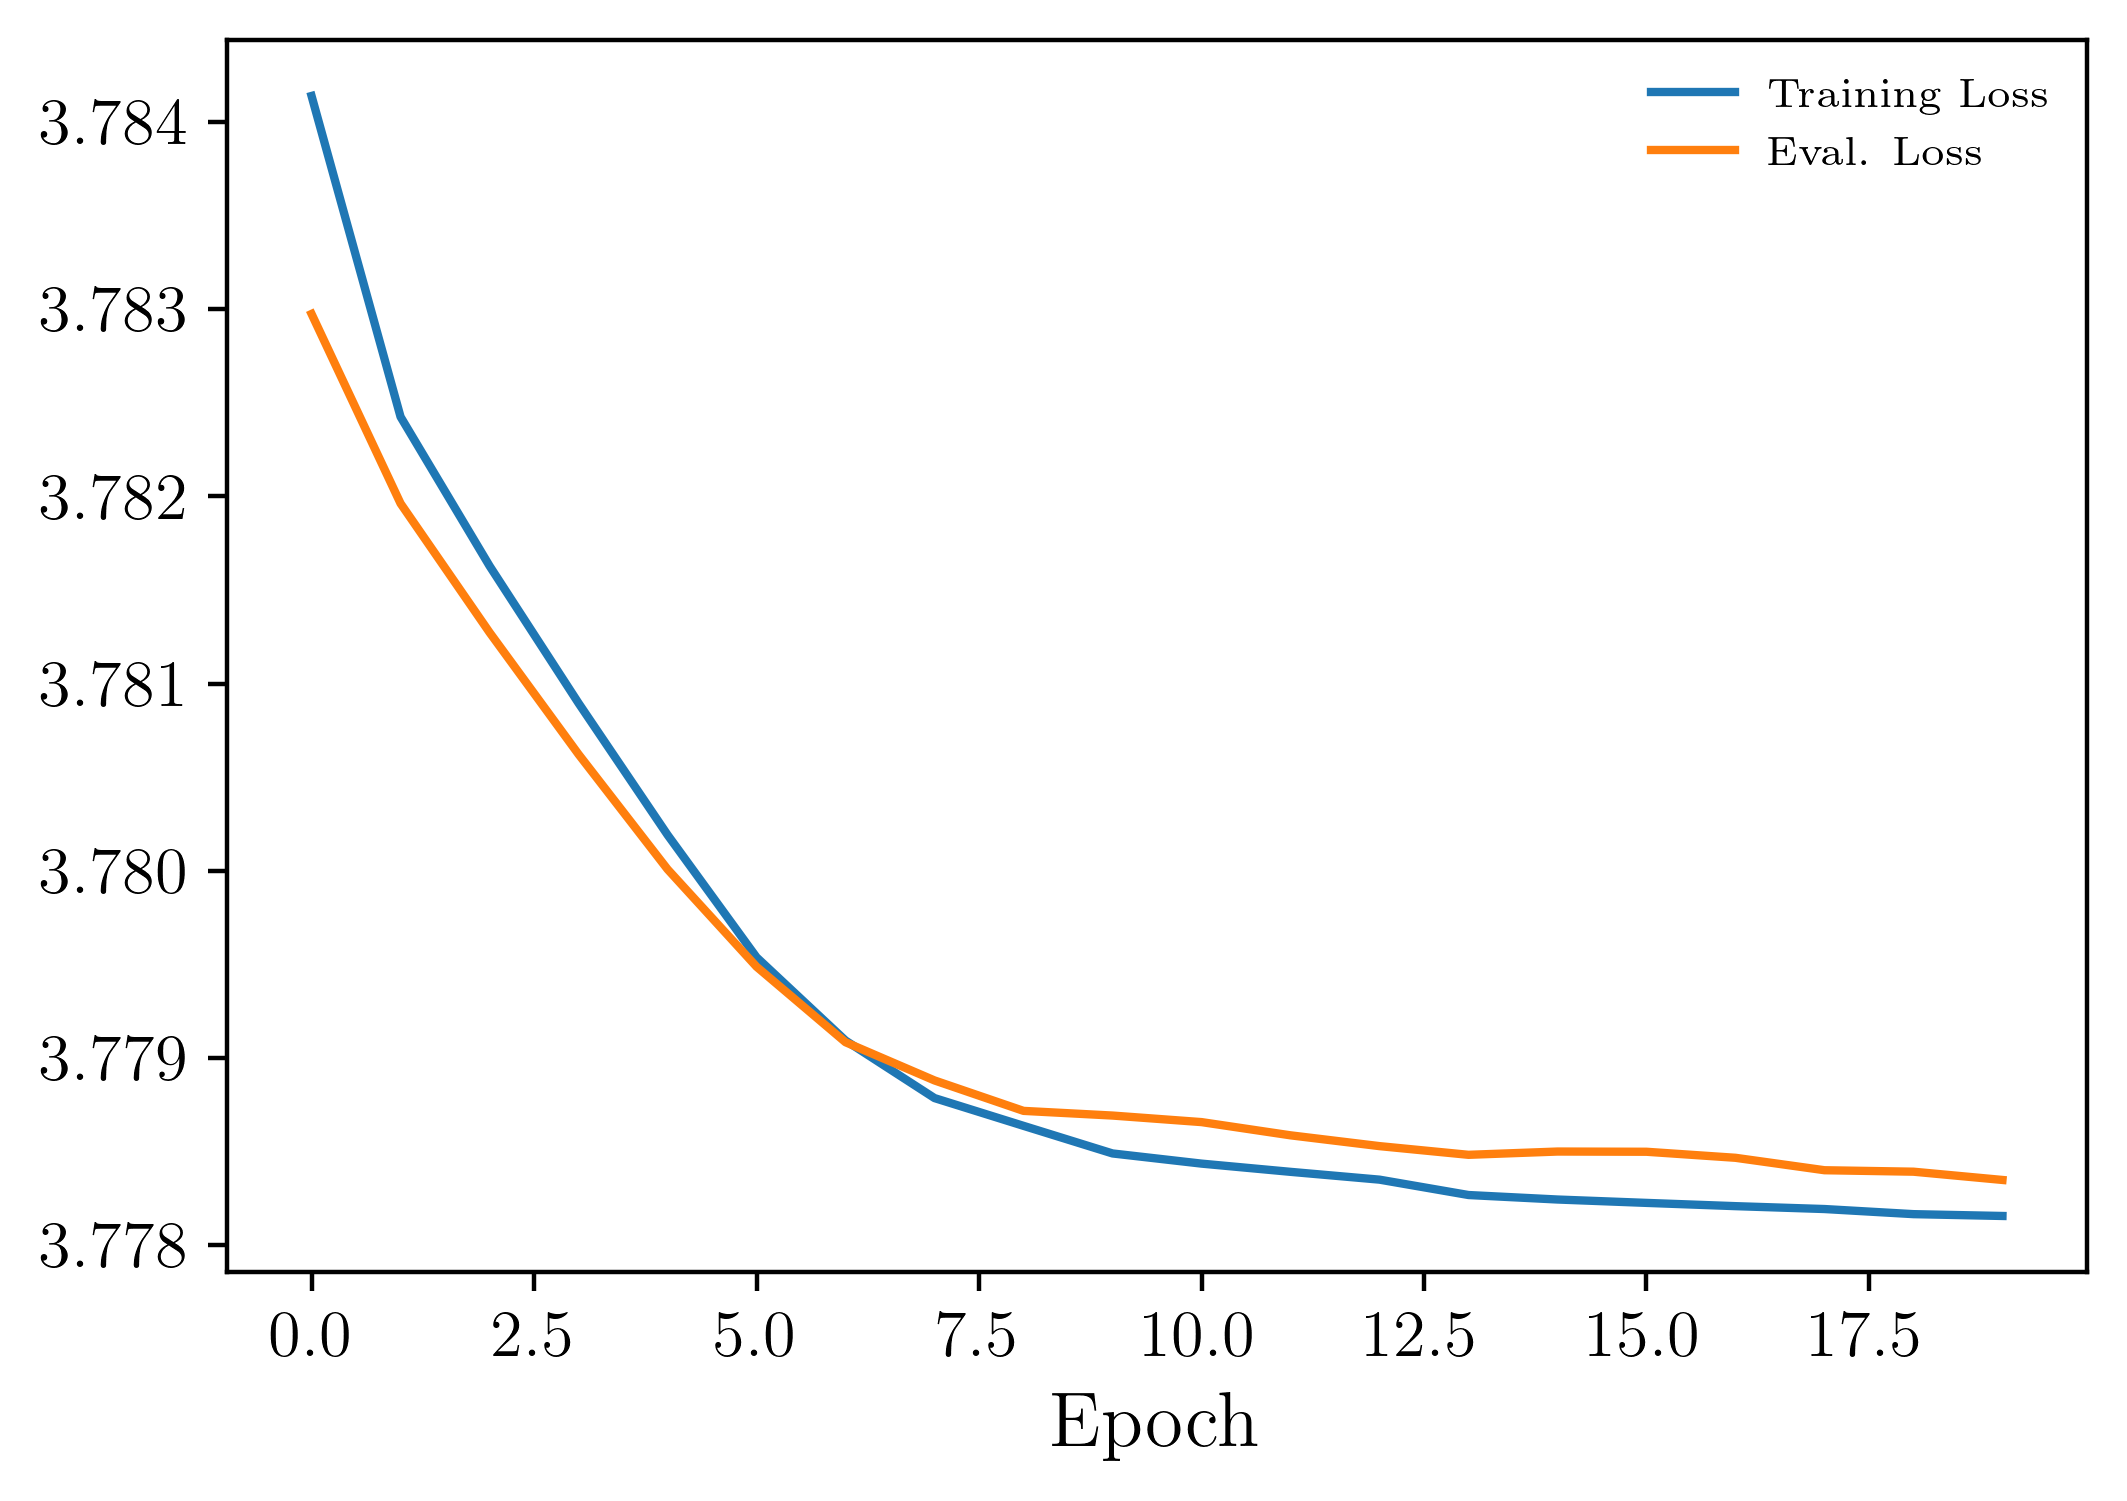

In [7]:
retrain = True
model = Event_By_Event_NN()

if retrain:
    learning_rate = 4e-4
    epochs = 20
    train_batch_size = 1_056_000
    eval_batch_size = 1_056_000
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    loss_table = train_and_eval(model, train_dataset, eval_dataset, loss_fn, optimizer, epochs, train_batch_size, eval_batch_size, device, move_data=False)
    torch.save(model.state_dict(), model_save_path)
    _, ax = plt.subplots()
    plot_loss_curves(loss_table["epoch"], loss_table["train_loss"], loss_table["eval_loss"], ax)
    plt.show()
else:
    model.load_state_dict(torch.load(model_save_path, weights_only=True))
    model.to(device)

Evaluate Model

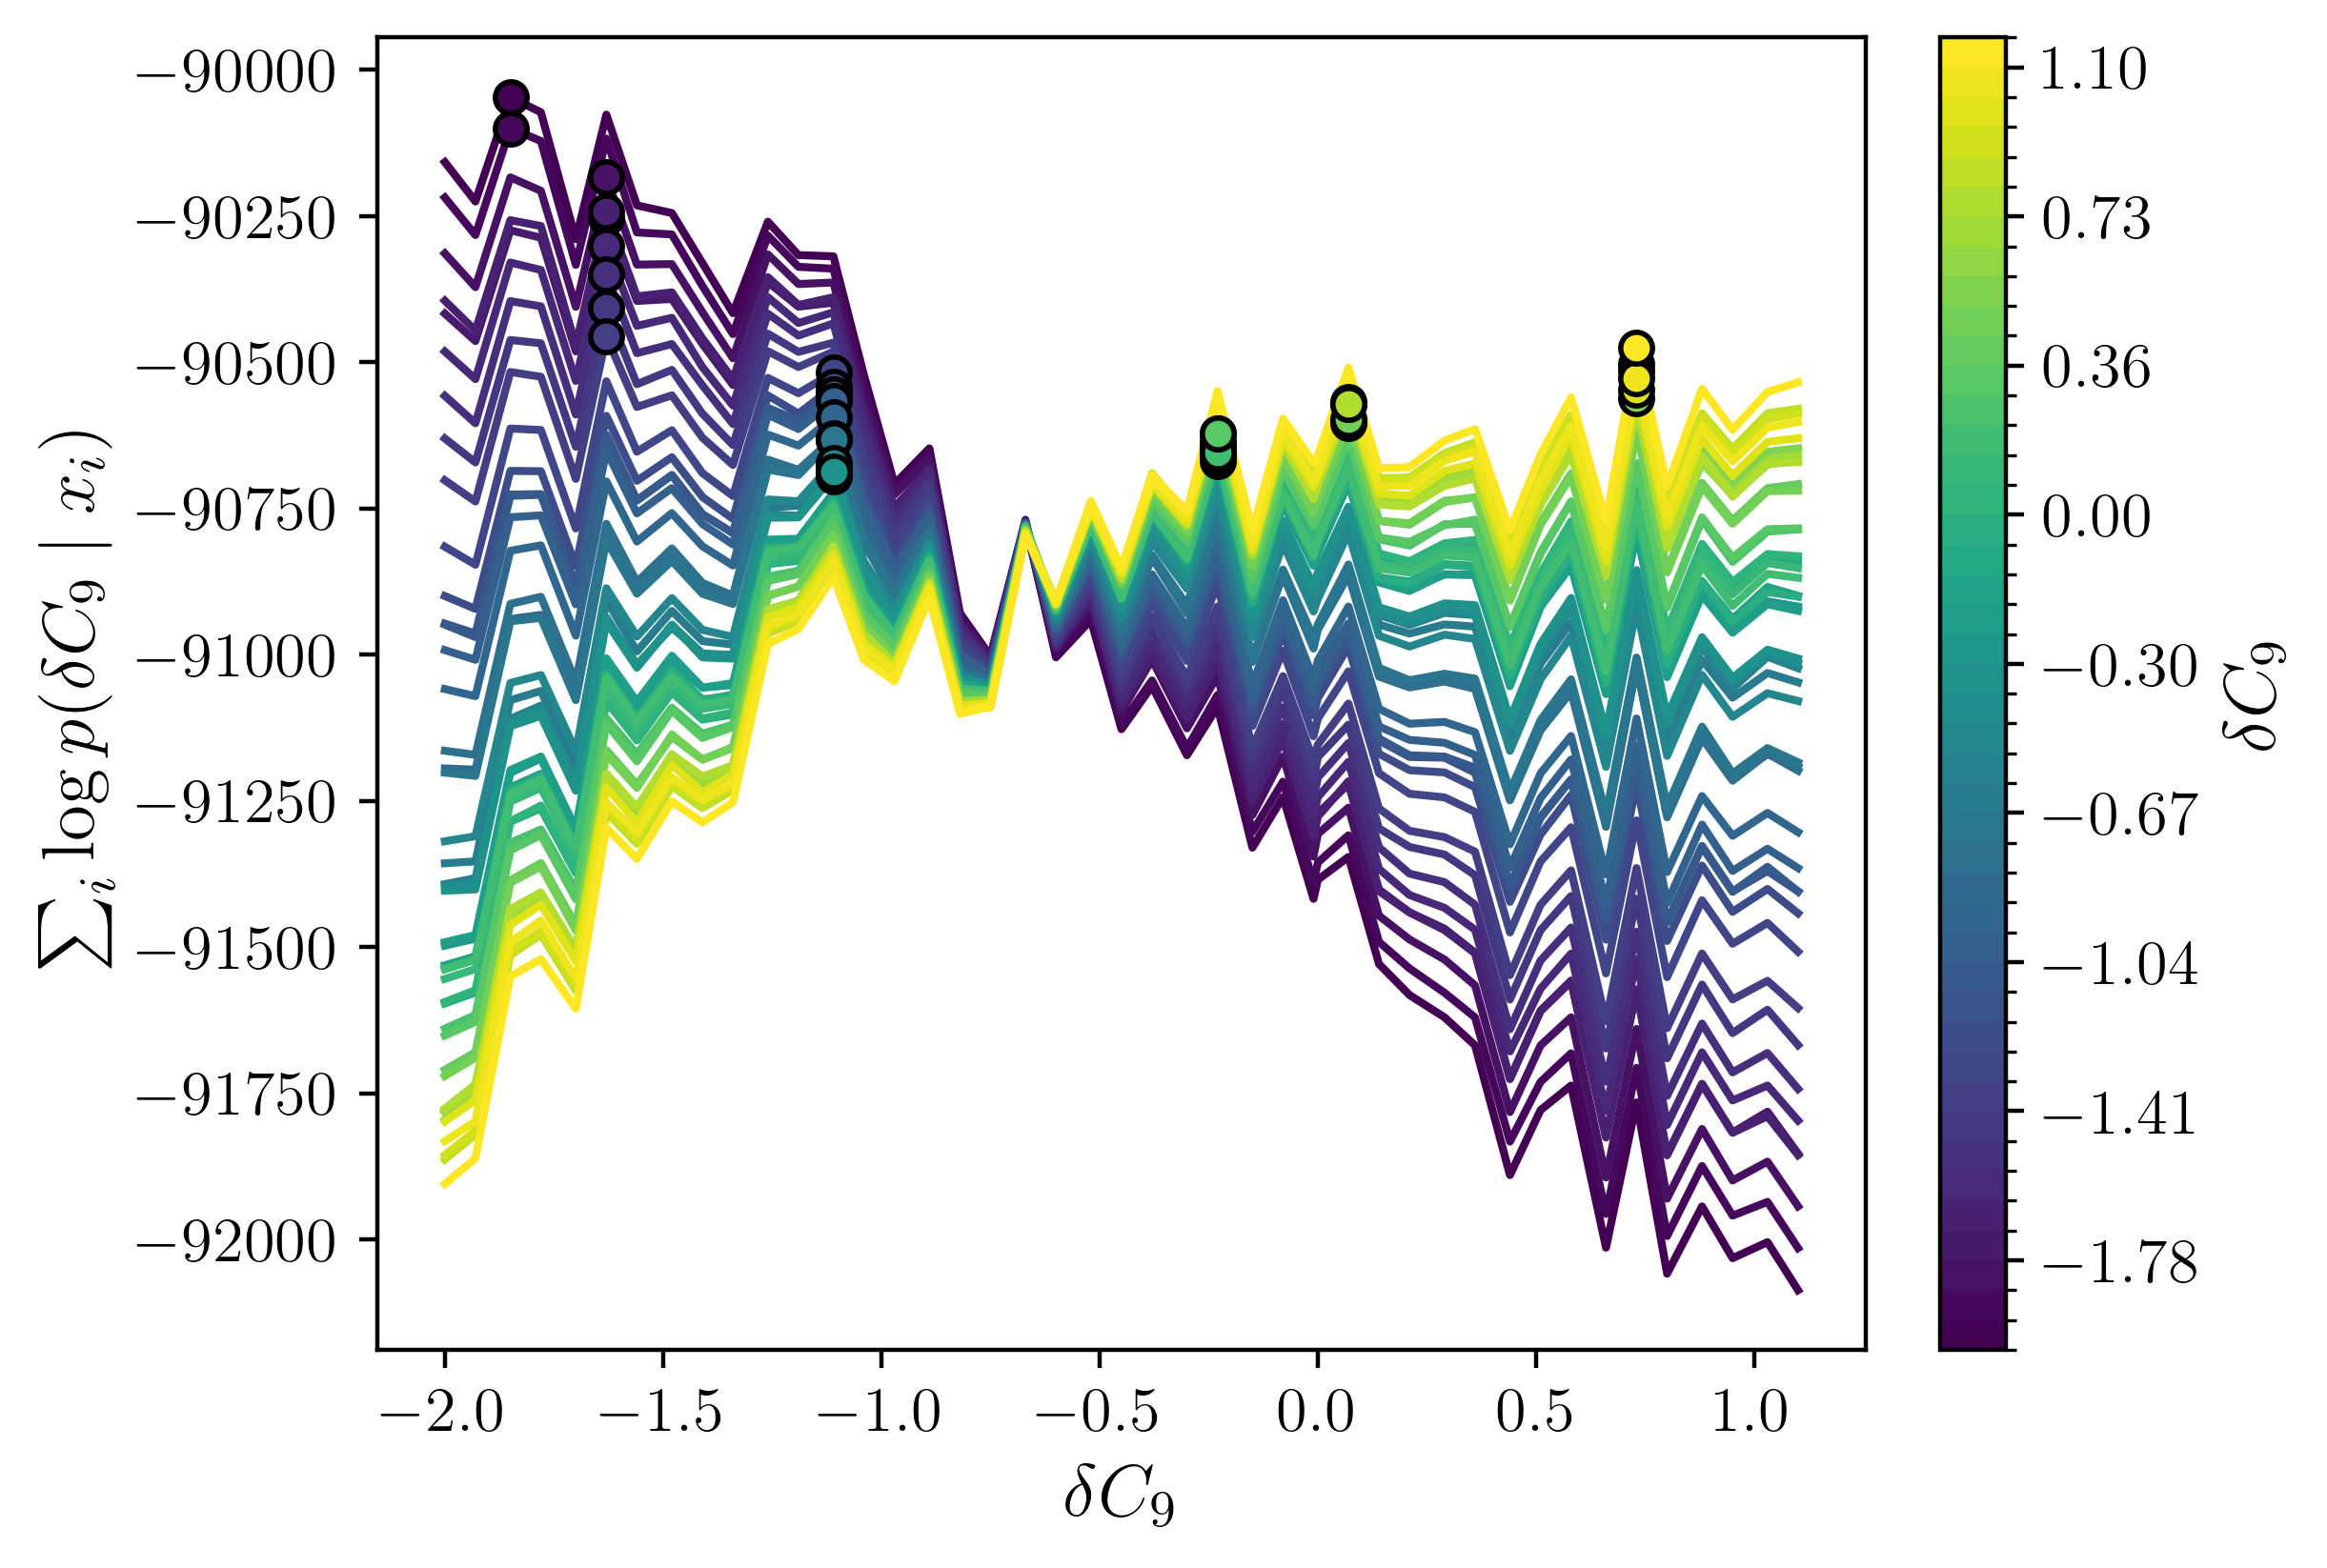

In [13]:

boot_x, boot_y = bootstrap_over_bins(
    eval_dataset.feat.cpu(), eval_dataset.labels.cpu(), 24_000)

preds = predict_likelihood_over_bins(
    torch.from_numpy(boot_x).to(device), torch.from_numpy(boot_y).to(device), model)

plot_likelihood_over_bins(preds, eval_dataset.bin_values)


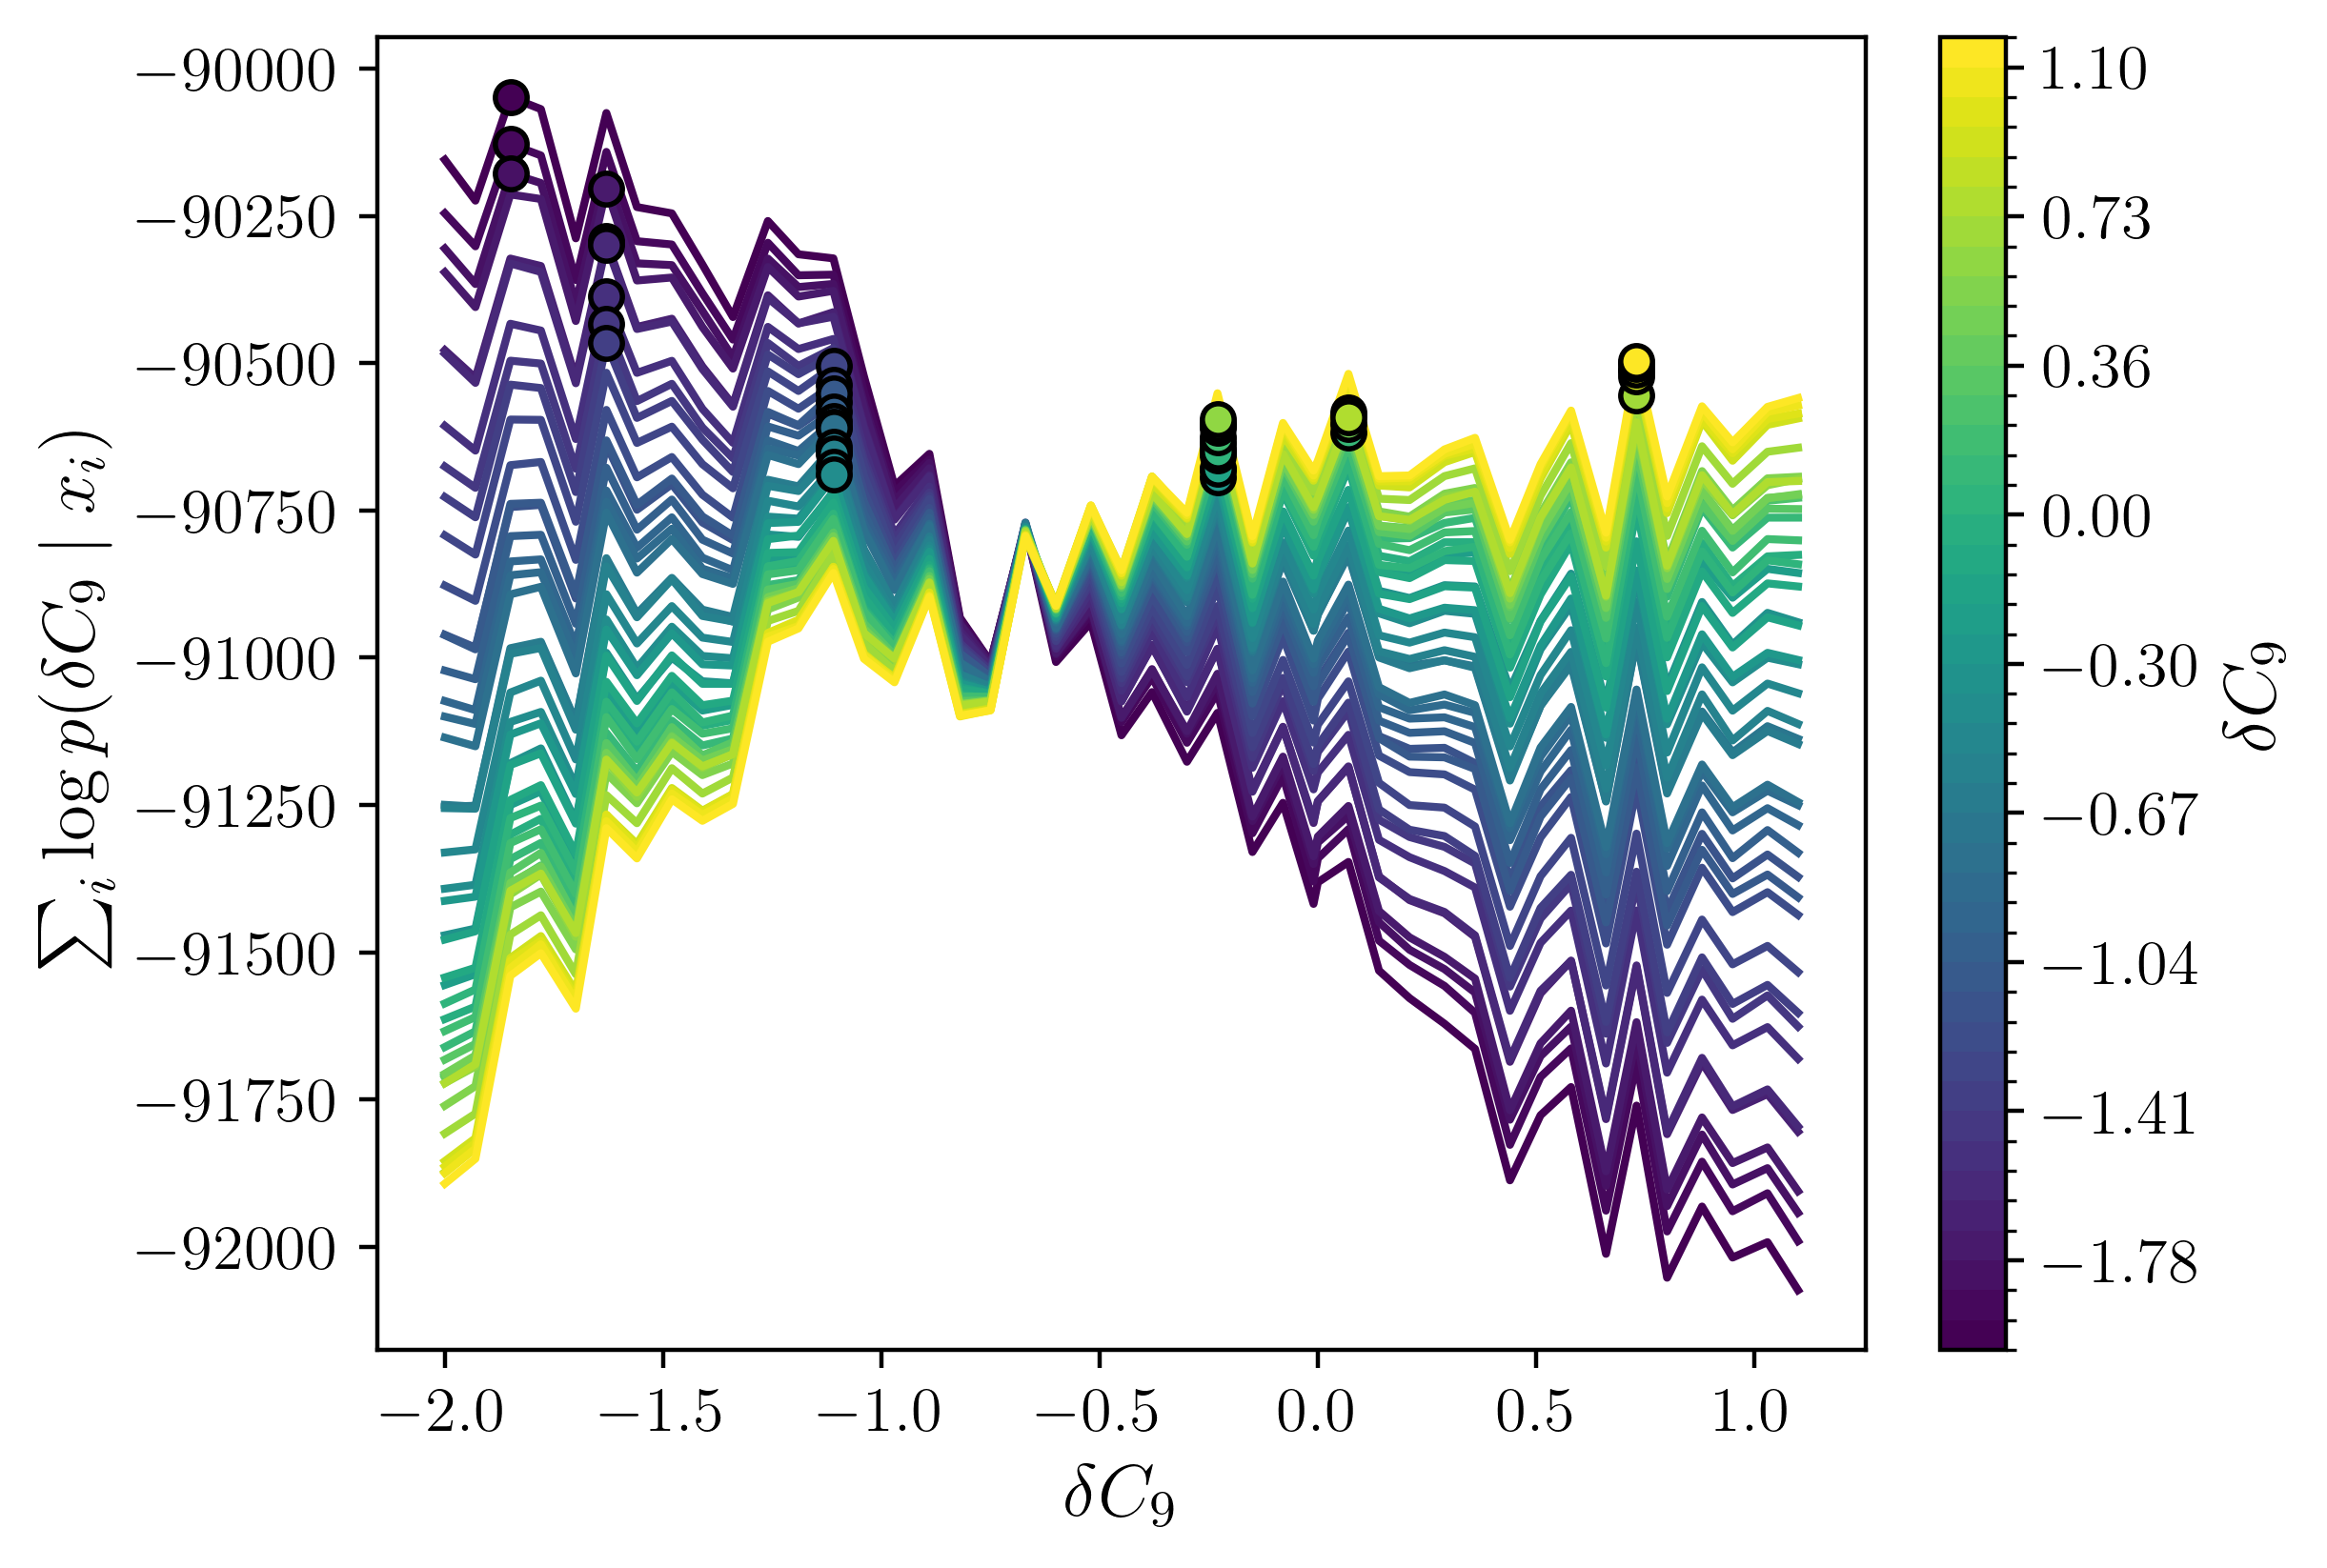

In [14]:
boot_x, boot_y = bootstrap_over_bins(
    train_dataset.feat.cpu(), train_dataset.labels.cpu(), 24_000)

preds = predict_likelihood_over_bins(
    torch.from_numpy(boot_x).to(device), torch.from_numpy(boot_y).to(device), model)

plot_likelihood_over_bins(preds, eval_dataset.bin_values)

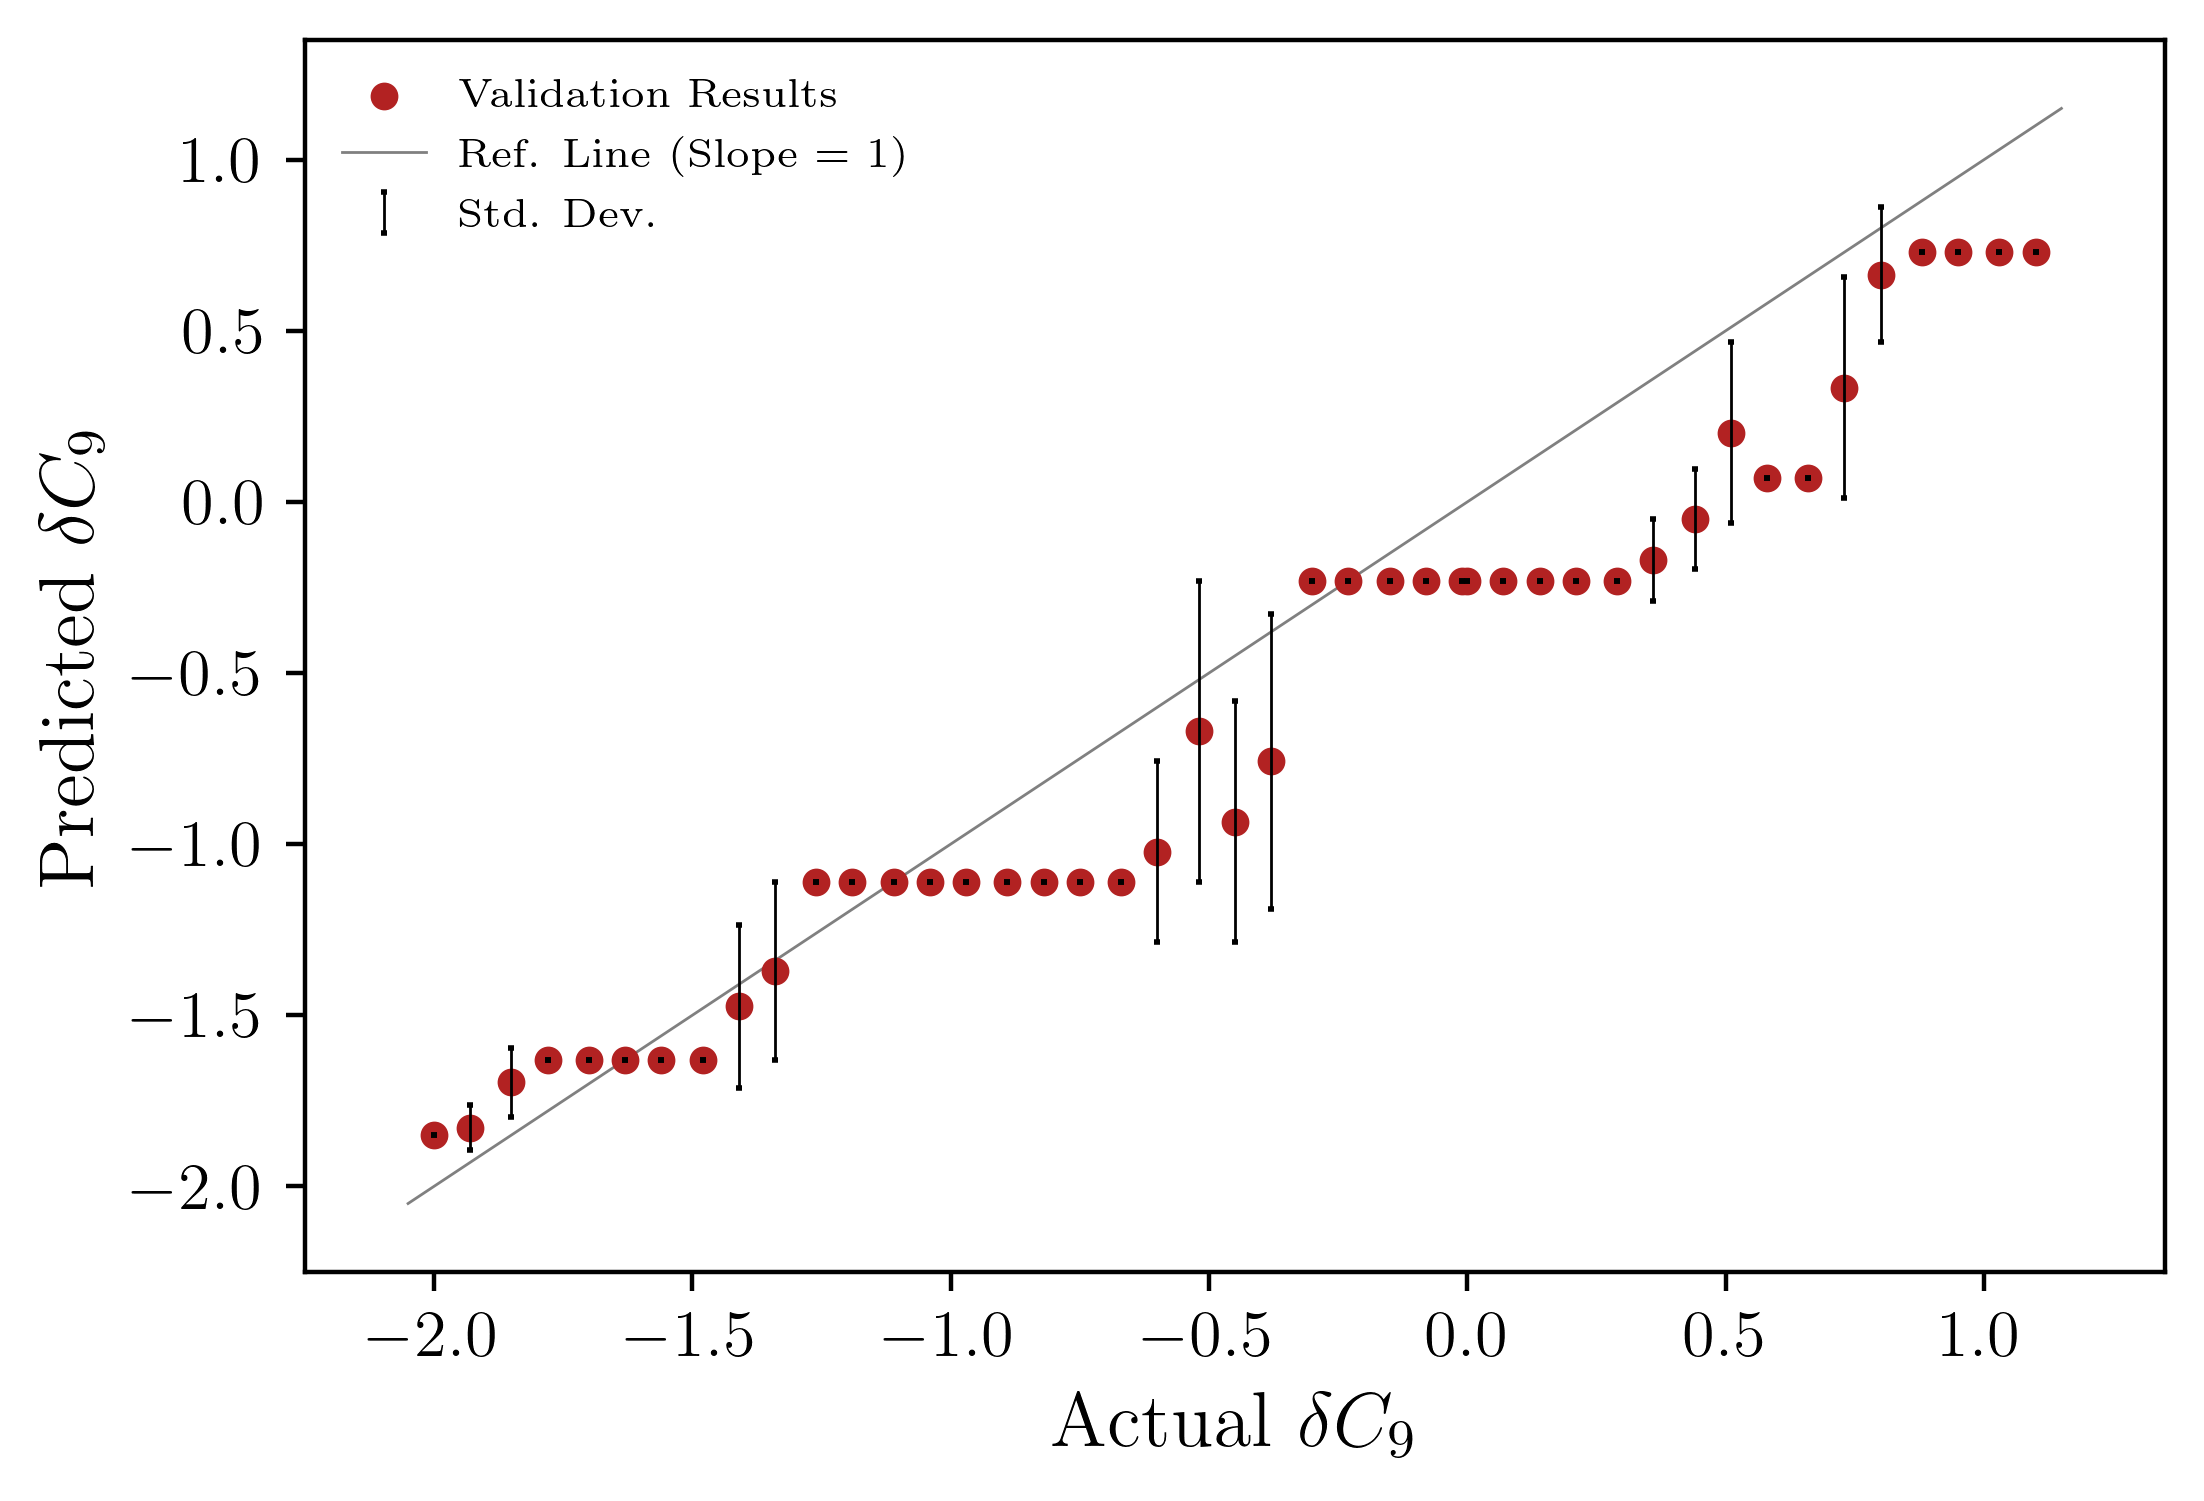

In [15]:
pred_bins_over_trials = predict_likelihood_over_bootstrapped_trials(
    eval_dataset.feat, 
    eval_dataset.labels, 
    n_trials=10,
    n_events=24_000,
    model=model,
    device=device    
)

pred_values_over_trials = eval_dataset.bin_values[pred_bins_over_trials]
avg_pred_values_over_trials = np.mean(pred_values_over_trials, axis=0)
stdev_pred_values_over_trials = np.std(pred_values_over_trials, axis=0)

plot_prediction_linearity(
    eval_dataset.bin_values,
    avg_pred_values_over_trials,
    stdev_pred_values_over_trials,
    ref_line_buffer=0.05,
    xlim=(-2.25, 1.35),
    ylim=(-2.25, 1.35),
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)


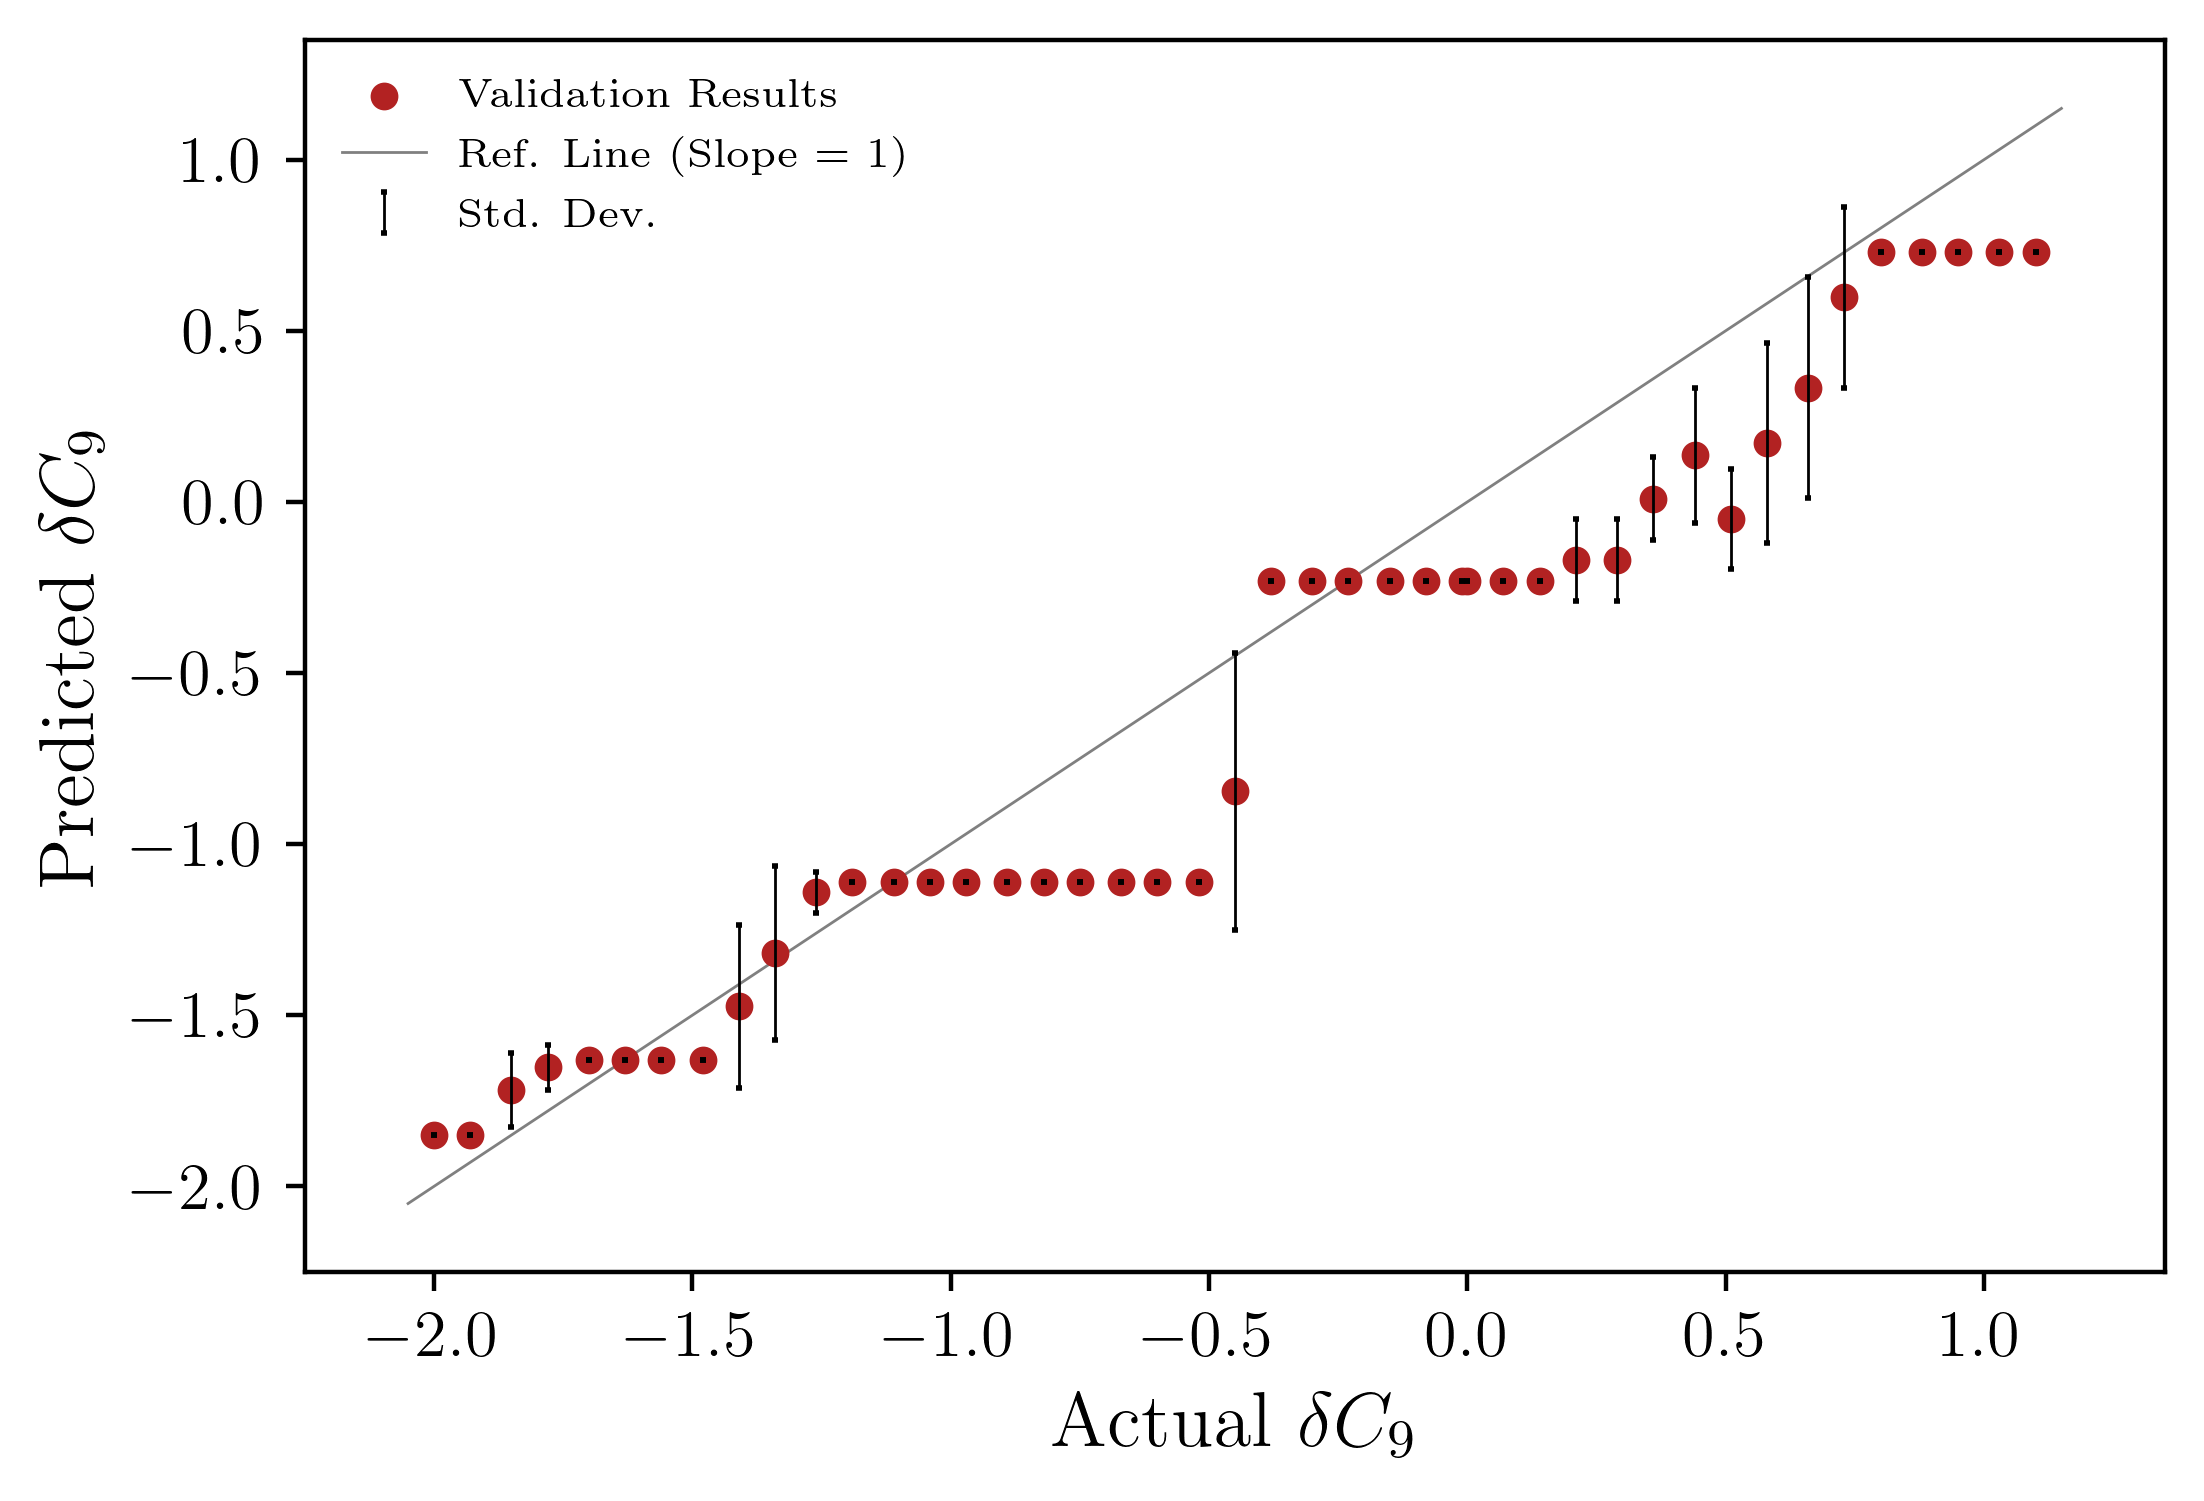

In [16]:
pred_bins_over_trials = predict_likelihood_over_bootstrapped_trials(
    train_dataset.feat, 
    train_dataset.labels, 
    n_trials=10,
    n_events=24_000,
    model=model,
    device=device    
)

pred_values_over_trials = eval_dataset.bin_values[pred_bins_over_trials]
avg_pred_values_over_trials = np.mean(pred_values_over_trials, axis=0)
stdev_pred_values_over_trials = np.std(pred_values_over_trials, axis=0)

plot_prediction_linearity(
    eval_dataset.bin_values,
    avg_pred_values_over_trials,
    stdev_pred_values_over_trials,
    ref_line_buffer=0.05,
    xlim=(-2.25, 1.35),
    ylim=(-2.25, 1.35),
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)

In [12]:
l = MSELoss() 
l(model.layers[6].weight, torch.zeros_like(model.layers[6].weight))

NameError: name 'MSELoss' is not defined